In [4]:
import pandas as pd

In [5]:
ls data/

reviews.csv  t.txt


In [6]:
data = pd.read_csv("data/reviews.csv", low_memory=False)

In [7]:
data.head()

,business_id,stars,useful,funny,cool,text,date
0,-MhfebM0QIsKt87iDN-FNw,2.0,5.0,0.0,0.0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,lbrU8StCq3yDfr-QMnGrmQ,1.0,1.0,1.0,0.0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,HQl28KMwrEKHqhFrrDqVNQ,5.0,1.0,0.0,0.0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,5JxlZaqCnk1MnbgRirs40Q,1.0,0.0,0.0,0.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,IS4cv902ykd8wj1TR0N3-A,4.0,0.0,0.0,0.0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [2]:
data.dtypes

business_id     object
stars          float64
useful         float64
funny          float64
cool           float64
text            object
date            object
dtype: object

We want to change stars to dtype float64 to check for correlation between stars and 'useful', 'funny', 'cool'

In [12]:
data.stars.unique()

array(['2.0', '1.0', '5.0', '4.0', '3.0', '2014-06-10 22:31:23',
       '2017-02-22 01:24:23'], dtype=object)

stars should only be values 1-5, but there are a couple corrupted samples.

In [14]:
data.loc[data['stars'] == '2014-06-10 22:31:23']

,business_id,stars,useful,funny,cool,text,date
1305521,All the goodness of the deep South! Seasoned a...,2014-06-10 22:31:23,NaN,NaN,NaN,NaN,NaN


In [15]:
data.loc[data['stars'] == '2017-02-22 01:24:23']

,business_id,stars,useful,funny,cool,text,date
1720478,My husband and I had not purchased a home befo...,2017-02-22 01:24:23,NaN,NaN,NaN,NaN,NaN


In [17]:
data = data[data.stars != '2014-06-10 22:31:23']

In [19]:
data = data[data.stars != '2017-02-22 01:24:23']

Now that the corrupted samples have been removed, we can convert the stars column to be of float datatype.

In [20]:
data['stars'] = data['stars'].astype(float)

## Data Exploration

In [21]:
data.corr().head()

,stars,useful,funny,cool
stars,1.000000,-0.088332,-0.041687,0.050560
useful,-0.088332,1.000000,0.669613,0.778529
funny,-0.041687,0.669613,1.000000,0.744910
cool,0.050560,0.778529,0.744910,1.000000


No noteworthy correlation between stars and counts of votes for 'userful', 'funny', and 'cool', so we will focus on sentiment analysis of the review text. 

In [25]:
data.count()

business_id    8021122
stars          8021122
useful         8021122
funny          8021122
cool           8021122
text           8021120
date           8021120
dtype: int64

We have two samples missing text and date

In [35]:
data = data.dropna(how='any',axis=0) 
#print(data[data["text"].isnull()])

In [36]:
data.count()

business_id    8021118
stars          8021118
useful         8021118
funny          8021118
cool           8021118
text           8021118
date           8021118
dtype: int64

We have dropped rows with null values

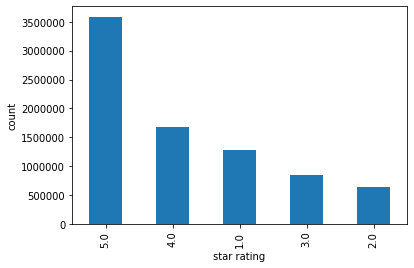

In [43]:
import matplotlib.pyplot as plt
data['stars'].value_counts().plot(kind='bar')
plt.xlabel("star rating")
plt.ylabel("count")
plt.show()

We see that there are many more positive reviews than negative to neutral reviews.

Based on this paper: https://pdfs.semanticscholar.org/224b/ec95ba091211979094aa2cc111ab9eabbb44.pdf
we will build models after random undersampling to balance the dataset, and we will also build models on the original dataset

In [10]:
pip install dill

     |████████████████████████████████| 151 kB 1.3 MB/s eta 0:00:01
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78530 sha256=df52c3dd89d148816c113954f1374dc568b7a6cc498ad463008cae5e1e05d6de
  Stored in directory: /Users/isabelli/Library/Caches/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
Successfully built dill
Note: you may need to restart the kernel to use updated packages.


In [4]:
data.columns

Index(['business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date'], dtype='object')

Let us also consider the length of the review in training our model

In [5]:
data['length'] = data['text'].apply(len)
data.head()

,business_id,stars,useful,funny,cool,text,date,length
0,-MhfebM0QIsKt87iDN-FNw,2.0,5.0,0.0,0.0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16,1373
1,lbrU8StCq3yDfr-QMnGrmQ,1.0,1.0,1.0,0.0,I am actually horrified this place is still in...,2013-12-07 03:16:52,1407
2,HQl28KMwrEKHqhFrrDqVNQ,5.0,1.0,0.0,0.0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11,431
3,5JxlZaqCnk1MnbgRirs40Q,1.0,0.0,0.0,0.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52,401
4,IS4cv902ykd8wj1TR0N3-A,4.0,0.0,0.0,0.0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57,841


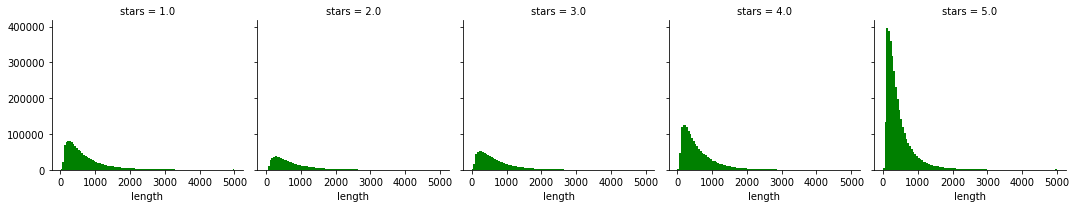

In [9]:
import seaborn as sns
graph = sns.FacetGrid(data=data,col='stars')
graph.map(plt.hist,'length',color='green', bins=100)

In [19]:
avg_mean = data.groupby('stars').length.mean()
print(avg_mean)

stars
1.0    748.071207
2.0    750.682093
3.0    700.996974
4.0    614.334491
5.0    471.373851
Name: length, dtype: float64


We see that 5 star reviews tend to be the shortest

In [44]:
import dill
dill.dump_session('notebook_env.db')

In [1]:
import dill
dill.load_session('notebook_env.db')